# Heat conduction of Composites

The aim of this lab is to investigate the heat conduction of composite materials. We will investigate the relation between effective heat conductivity and phase fraction of a "made-up" 2D composite.

## Computational domain

We have provided a set of three black-and-white images that will serve as our composites. These types of images can be obtained from X-Ray tomography data, microscopes (incl. SEM). Usually, they are grayscale and we have simply thresholded them.

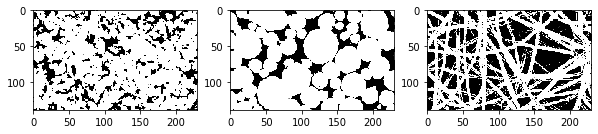

In [1]:
import matplotlib.pyplot as plt

composite1 = plt.imread('images/composite_1.tif')
composite2 = plt.imread('images/composite_2.tif')
composite3 = plt.imread('images/composite_3.tif')

fig=plt.figure(figsize=(10, 8));
fig.add_subplot(1, 3, 1);
plt.imshow(composite1);
fig.add_subplot(1, 3, 2);
plt.imshow(composite2);
fig.add_subplot(1, 3, 3);
plt.imshow(composite3);

These are TIFF images with a dynamic range from 0 to 255. The image size is 230x140. The first composite contains fairly small particles in a random arrangement. The second composite is similar but with much larger roughly spherical particles. The third composite is made of fibres.

## Phase fractions

Lets investigate the phase fractions of all three structures. We will do this by counting the number of white/black pixels relative to the total number of pixels.

In [2]:
import numpy as np;
phasefraction_1 = np.sum(composite1 > 120) / composite1.size;
phasefraction_2 = np.sum(composite2 > 120) / composite2.size;
phasefraction_3 = np.sum(composite3 > 120) / composite3.size;

print("Phase fraction Composite 1: {:6.3f}".format(phasefraction_1));
print("Phase fraction Composite 2: {:6.3f}".format(phasefraction_2));
print("Phase fraction Composite 3: {:6.3f}".format(phasefraction_3));

Phase fraction Composite 1:  0.793
Phase fraction Composite 2:  0.807
Phase fraction Composite 3:  0.567


In [3]:
# ACTION: Compute phase fractions of "black" phases and confirm that they add up to one.

## Heat conductivity

The heat conductivity is taken to be

$$
\lambda(x,\alpha) = 1\,\text{for "white" phase}
$$
and

$$
\lambda(x,\alpha) = \alpha\,\text{for "black" phase}
$$

which is a form of relative heat conductivity.

## Computational Problem

We will investigate the stationary temperature distrubution $u(x)$ of a composite materials subjected to a constant temperature at difference across two borders of $\Delta u = 2$. We will use normalised quantities to not be bothered with units etc. So the temperature change goes from $u=1$ to $u=-1$ on the left/right boundaries. The top/bottom boundaries will be modelled as "no flux" boundaries (i.e., homogeneous Neumann BCs) The problem is described by this PDE

$$
\nabla (\lambda(x) \nabla u) = 0\\
u = -1\,\text{on}\,\Gamma_L\\
u = +1\,\text{on}\,\Gamma_R\\
\nabla u = 0 \,\text{on}\,\Gamma_T,\Gamma_B\\
$$

with the inhomogeneous heat conductivity $\lambda(x)$. We will use a domain decomposition, splitting the system of equations into

$$
\nabla^2 u = 0\quad\text{on}\quad\Omega_1\\
\alpha \nabla^2 u = 0\quad\text{on}\quad\Omega_2
$$

# FEM solution

## Parameters

In [4]:
## Define current values <-- CHANGE here to investigate other composites -->

## Numerical parameter
nx = 50      # Grid-size horizontal
ny = 30      # Grid-size vertical

## Materials parameter
composite = composite2
alpha = 0.05

## Mesh and Function space

We will operate on a triangular mesh with piecewise linear functions

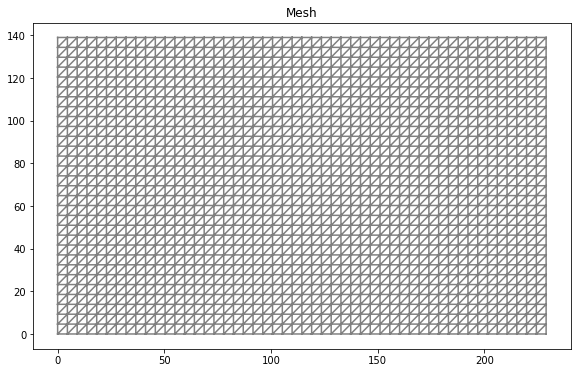

In [5]:
from dolfin import *;
import matplotlib.pyplot as plt;

mesh = RectangleMesh(Point(0.0,0.0),Point(229.,139.),50,30);
V = FunctionSpace(mesh, "Lagrange", 1);

plt.figure(figsize=(10,6));
plot(mesh, title="Mesh");

## Subdomains

We will use `SubDomains` to define the different parts of the domain. This includes boundaries and the internal phase regions.

In [6]:
# Create classes for defining parts of the boundaries and the interior
# of the domain

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 229.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 139.0)

# The v class manages the internal phases. Instances of this class
# are initialised with an image array holding the phase information as 
# images. We threshold at a mean value of 120 across the Red, Green, and Blue 
# color values in the TIFF images. TIFF images scale from 0 to 255 for each of
# the three primary colors.
class WhitePhase(SubDomain):
    
    c = [];
    
    def __init__(self,c):
        super(WhitePhase, self).__init__()
        self.c = c;
    
    def inside(self, x, on_boundary):
        return np.mean(composite[int(np.floor(x[1])),int(np.floor(x[0])),:]) > 120;

# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
white = WhitePhase(composite)

FEniCS meshes carry an index that allows to define measures for subdomains. We will use this feature to mark the different parts of the computational domain. We define a `MeshFunction` over the mesh cells to indicate which cells that correspond to the different interior subregions $\Omega_0$ and $\Omega_1$. Those in the "white" phase will be tagged by 1, while the remainder is tagged by 0. We can set all the values of a `MeshFunction` to a given value using the `set_all` method. So, in order to accomplish what we want, we can set all values to 0 first, and then we can use the obstacle instance to mark the cells identified as inside the obstacle region by 1 (thus overwriting the previous value):

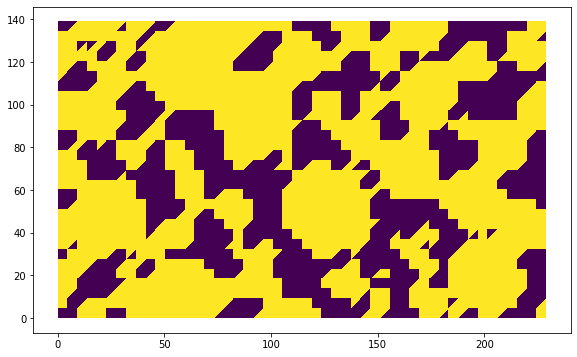

In [7]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
white.mark(domains, 1)

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

plt.figure(figsize=(10,6));
plot(domains);

## Define FEM problem and solve

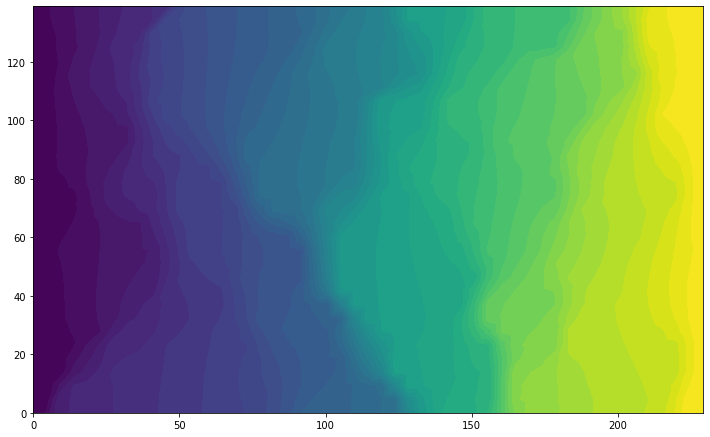

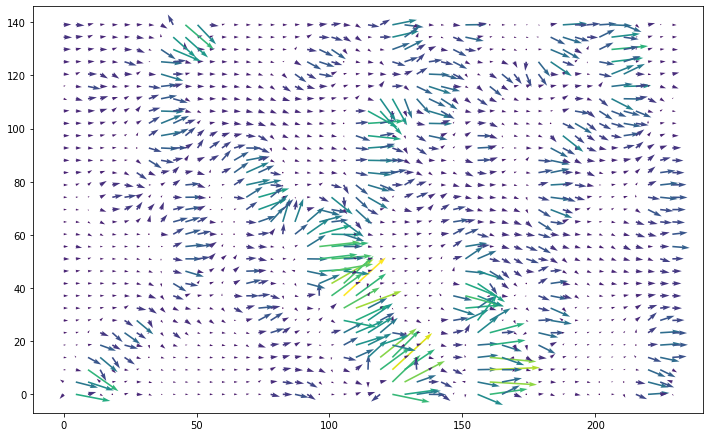

In [8]:
# Define heat conductivies for
l0 = Constant(alpha)
l1 = Constant(1.0)

# Fluxes on the top and bottom boundary are set to zero
# Note that we still need to define this Neumann boundary
# condition even though it evaluates to zero.
g_T = Constant(0.0)
g_B = Constant(0.0)

# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domains)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define trial and test functions over function space
u = TrialFunction(V);
v = TestFunction(V);

# Define bilinear and linear form
a0 = inner(l0*grad(u), grad(v))*dx(0);
a1 = inner(l1*grad(u), grad(v))*dx(1);
a = a0 + a1;
L = g_B*v*ds(2) + g_T*v*ds(4);

# Define Dirichlet boundary conditions at left and right boundaries
bcs = [DirichletBC(V, -1.0, boundaries, 1),
       DirichletBC(V,  1.0, boundaries, 3)]

# Solve problem
u = Function(V)
solve(a == L, u, bcs);

plt.figure(figsize=(12,10));
plot(u);
plt.figure(figsize=(12,10));
plot(grad(u));

# Analysis

We are interested in the flux through the left and right boundaries for the temperature difference $\Delta u = 2$ that we have imposed on the domain. The heat flux is given by

$$
J=\int_{\partial \Omega} \lambda(x) (\nabla u\cdot {\bf n})\,ds
$$

To evaluate that integral, we need to construct a `Function` of the heat conductivity first on the `FunctionSpace` $V$. This can be done by looking up the coordinates of all degrees of freedom (dof) of $V$ and equate them to the respective pixel in the TIFFs.

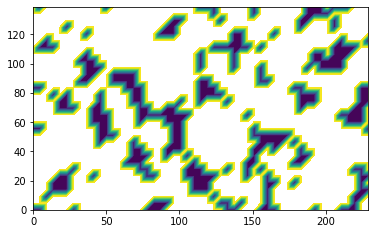

In [9]:
def lmbda(x):
    return (int(white.inside(x,True)) * 1.0 + int(not white.inside(x,True)) * alpha);

l = Function(V);
l.vector()[:] = [lmbda(x) for x in V.tabulate_dof_coordinates()]
plot(l);

Now we can evaluate the fluxes across the boundaries

In [10]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh);
m_L = l*dot(grad(u), n)*ds(1);
v_L = assemble(m_L);
m_B = l*dot(grad(u), n)*ds(2);
v_B = assemble(m_B);
m_R = l*dot(grad(u), n)*ds(3);
v_R = assemble(m_R);
m_T = l*dot(grad(u), n)*ds(4);
v_T = assemble(m_T);

print("Flux through left boundary = ", v_L);
print("Flux through right boundary = ", v_R);
print("Flux through bottom boundary = ", v_B);
print("Flux through top boundary = ", v_T);

Flux through left boundary =  -0.6354133912291149
Flux through right boundary =  0.9508991744180892
Flux through bottom boundary =  -0.060821456975345536
Flux through top boundary =  0.008566511446080992


**The left and boundary fluxes do not agree!!! Somethingh is wrong.** Conservation of energy should lead to the same flux into the domain from the left and out of the domain at the right.

This is a subtle consequence of our choice of discretisation. One consequence of our approach to use domain decomposition should be that flux is conserved across the internal domain boundaries:

$$
(\nabla u\cdot {\bf n})_1 = \alpha (\nabla u \cdot {\bf n})_2\quad\text{on}\quad \partial\Omega_{1|2}
$$

This, however, is nowhere enforced. FEniCS simply ensures that the problem is valid for each element and that the temperature field is continuous, but Finite-Elements are not conservative by construction. This highlights one of many subleties that can result from practical choices that can lead to inaccuracy even if everything is done "correctly".

For now, we will accept this as an inherent problem. You can take the average of both fluxes for further analysis.


## Relative flux and effective heat conductivity

The flux for a domain of the size (230x140) with a homogeneous conductivity of $\lambda = 1$ is

$$
J_h =h/w*\Delta u =  140/230*2 = 1.2173913
$$

we can, therefore, calculate effective conductivities by taking the ratio of fluxes.

In [11]:
effective_conductivity = (abs(v_L)+abs(v_R))/2. / (140./230.*2.); 
print("Effective relative conductivity: {:6.3f}".format(effective_conductivity))

Effective relative conductivity:  0.652
